# Urban-Plumber2: UK-Kin site CLMU5 simulation


In [1]:
from pyclmuapp import usp_clmu
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
%%time
# initialize
usp = usp_clmu()

# here we use the default surface data, which is the london uk-kin data
# lat = 51.5116, lon = -0.1167
# this forcing derived from urban-plumber forcing data

usp_london = usp.run(
            case_name = "UK_Kin_default", 
            SURF="surfdata.nc",
            FORCING="forcing.nc",
            RUN_STARTDATE = "2002-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "12",
        )
usp_london

Copying the file forcing.nc to the /Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/val/workdir/inputfolder/usp
CPU times: user 1.51 s, sys: 560 ms, total: 2.07 s
Wall time: 9min 13s


['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/val/workdir/outputfolder/lnd/hist/UK_Kin_default_clm0_2024-11-25_20-00-35_clm.nc']

In [3]:
london_nc = usp.nc_view(usp_london[0]).sel(time=slice('2012-01-01', '2014-12-31'))
london_nc

<xarray.Dataset> Size: 25MB
Dimensions:             (levgrnd: 25, levlak: 10, levdcmp: 1, time: 35089,
                         hist_interval: 2, lndgrid: 1, column: 6, gridcell: 1,
                         landunit: 2, pft: 6, levsoi: 20)
Coordinates:
  * levgrnd             (levgrnd) float32 100B 0.01 0.04 0.09 ... 28.87 42.0
  * levlak              (levlak) float32 40B 0.05 0.6 2.1 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 4B 1.0
  * time                (time) datetime64[ns] 281kB 2012-01-01 ... 2014-01-01
Dimensions without coordinates: hist_interval, lndgrid, column, gridcell,
                                landunit, pft, levsoi
Data variables: (12/129)
    mcdate              (time) int32 140kB ...
    mcsec               (time) int32 140kB ...
    mdcur               (time) int32 140kB ...
    mscur               (time) int32 140kB ...
    nstep               (time) int32 140kB ...
    time_bounds         (time, hist_interval) datetime64[ns] 561kB ...
    ...                  ...
    URBAN_AC            (time, gridcell) float32 140kB ...
    URBAN_HEAT          (time, gridcell) float32 140kB ...
    WASTEHEAT           (time, gridcell) float32 140kB ...
    WBT                 (time, gridcell) float32 140kB ...
    Wind                (time, gridcell) float32 140kB ...
    ZWT                 (time, gridcell) float32 140kB ...
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 11/25/24 19:52:34
    source:                                    Community Land Model CLM4.0
    hostname:                                  clmu-app
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          minute_30

import the observation data for comparison

In [4]:
ds = xr.open_dataset('/Users/user/Documents/GitHub/pyclmuapp/inputfolder/Urban-PLUMBER/datm_files/UK-Kin/CLM1PT_data/UK-KingsCollege_clean_observations_v1.nc')
ds

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 30577)
Coordinates:
  * time       (time) datetime64[ns] 245kB 2012-04-04 ... 2014-01-01
Data variables: (12/28)
    SWdown     (time) float32 122kB ...
    LWdown     (time) float32 122kB ...
    Tair       (time) float32 122kB ...
    Qair       (time) float32 122kB ...
    PSurf      (time) float32 122kB ...
    Rainf      (time) float32 122kB ...
    ...         ...
    Wind_E_qc  (time) int8 31kB ...
    SWup_qc    (time) int8 31kB ...
    LWup_qc    (time) int8 31kB ...
    Qle_qc     (time) int8 31kB ...
    Qh_qc      (time) int8 31kB ...
    Qtau_qc    (time) int8 31kB ...
Attributes: (12/24)
    title:                      Flux tower observations from UK-KingsCollege ...
    summary:                    Quality controlled flux tower observations fo...
    sitename:                   UK-KingsCollege
    long_sitename:              Kings College, London, United Kingdom
    version:                    v1
    keywords:                   urban, flux tower, eddy covariance, observations
    ...                         ...
    observations_contact:       Simone Kotthaus (kotthaus@ipsl.polytechnique....
    observations_reference:     Bjorkegren et al. (2015): https://doi.org/10....
    date_created:               2022-09-22 16:27:09
    source:                     https://github.com/matlipson/urban-plumber_pi...
    comment:                    Observations from KSSW tower
    history:                    v0.9 (2021-09-08): beta issue; v1 (2022-09-15...

In [5]:
#round the time to the nearest minute
london_nc['time'] = london_nc['time'].dt.round('min')
# shift the time by 30 minutes to match the observations
london_nc['time'] = london_nc['time'] - np.timedelta64(1800, 's')
df = london_nc[['Qle','Qh','Qtau','SWup','LWup']].to_dataframe()
df_ds = ds[['Qle','Qh','Qtau','SWup','LWup']].to_dataframe()
df['Qtau'] = -df['Qtau']
df = df.merge(df_ds, on='time', suffixes=('_usp', '_obs'))
df.head(1)

,Qle_usp,Qh_usp,Qtau_usp,SWup_usp,LWup_usp,Qle_obs,Qh_obs,Qtau_obs,SWup_obs,LWup_obs
time,,,,,,,,,,
2012-04-04,31.69558,16.175985,0.030384,0.0,353.656372,NaN,NaN,NaN,NaN,NaN


In [6]:
%%time
# modify the surface

# tree_area_fraction=0.03
# grass_area_fraction=0.04
# bare_soil_area_fraction=0.0
# water_area_fraction=0.14
# impervious_area_fraction=0.79
# roof fraction = 0.4
# raod fraction = 0.39
# topsoil_clay_fraction=0.26
# topsoil_sand_fraction=0.45
# PCT_CLAY = 0.26
# PCT_SAND = 0.45
action = {

    #"ALB_ROOF_DIR": 0.109,
    #"ALB_ROOF_DIF": 0.109,
    "CANYON_HWR": 1.13,
    "HT_ROOF": 21.3,
    "WTLUNIT_ROOF": 0.4/(0.03+0.04+0.79),
    "WTROAD_PERV": 1 - 0.39/(0.03+0.04+0.39),
    #"ALB_IMPROAD_DIR": 0.109,
    #"ALB_IMPROAD_DIF": 0.109,
    #"ALB_PERROAD_DIR": 0.109,
    #"ALB_PERROAD_DIF": 0.109,
    #"WIND_HGT_CANYON": 50
}
usp.modify_surf(action=action, surfata_name="surface_modfied_UK_Kin.nc", mode="replace", urban_type=2)

CPU times: user 187 ms, sys: 53.7 ms, total: 241 ms
Wall time: 258 ms


In [7]:
usp_london_detail = usp.run(
            case_name = "UK_Kin_detail", 
            RUN_STARTDATE = "2002-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "12",
            RUN_TYPE= "coldstart",
        )
usp_london_detail

['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/val/workdir/outputfolder/lnd/hist/UK_Kin_detail_clm0_2024-11-25_20-09-43_clm.nc']

In [8]:
ludon_detail_nc = usp.nc_view(usp_london_detail[0]).sel(time=slice('2012-01-01', '2014-12-31'))
ludon_detail_nc['time'] = ludon_detail_nc['time'].dt.round('min')
ludon_detail_nc['time'] = ludon_detail_nc['time'] - np.timedelta64(1800, 's')
df_ds = ds[['Qle','Qh','Qtau','SWup','LWup']].to_dataframe()
df_detail = ludon_detail_nc[['Qle','Qh','Qtau','SWup','LWup']].to_dataframe()
df_detail['Qtau'] = -df_detail['Qtau']
df_detail = df_detail.merge(df_ds, on='time', suffixes=('_usp', '_obs'))
df_detail.head(1)

,Qle_usp,Qh_usp,Qtau_usp,SWup_usp,LWup_usp,Qle_obs,Qh_obs,Qtau_obs,SWup_obs,LWup_obs
time,,,,,,,,,,
2012-04-04,35.300236,16.307856,0.029534,0.0,352.476349,NaN,NaN,NaN,NaN,NaN


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import warnings
from datetime import datetime
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

def plotting(df, save_path):
    var_list = ['SWup','LWup','Qle','Qh','Qtau']
    unit = ['W/m$\mathrm{^{2}}$', 'W/m$\mathrm{^{2}}$', 'W/m$\mathrm{^{2}}$', 'W/m$\mathrm{^{2}}$', 'W/m$\mathrm{^{2}}$']
    lim = [[-10, 130], [280, 600], [-120, 350], [-150, 500], [-0.1, 1.3]]
    
    
    for var in var_list:
        fig = plt.figure(figsize=(12, 5))

        df_plot = df[[f'{var}_usp', f'{var}_obs']].dropna()
        df_mean = df_plot[[f'{var}_usp', f'{var}_obs']].groupby(df_plot.index.hour).mean()
        df_std = df_plot[[f'{var}_usp', f'{var}_obs']].groupby(df_plot.index.hour).std()
        
        mae = mean_absolute_error(df_plot[f'{var}_obs'],df_plot[f'{var}_usp'])
                            #mean_absolute_percentage_error(df_plot[f'{var}_usp'], df_plot[f'{var}_obs'])#mean_squared_error(df_plot[f'{var}_usp'], df_plot[f'{var}_obs'])
        R, _ = pearsonr(df_plot[f'{var}_usp'], df_plot[f'{var}_obs'])
        
        ax = fig.add_subplot(1, 2, 1)
        
        if var == 'SWup':
            for h in range(0,24):
                if h not in df_mean.index:
                    df_mean.loc[h] = [0,0]
                    df_std.loc[h] = [0,0]
        df_mean = df_mean.sort_index()
        df_std = df_std.sort_index()
        
        ax.plot(df_mean.index, df_mean[f'{var}_usp'], color="#E02927", label='Simulated')
        ax.fill_between(df_mean.index, df_mean[f'{var}_usp']-df_std[f'{var}_usp'], df_mean[f'{var}_usp']+df_std[f'{var}_usp'], color="#E02927", alpha=0.2)
        ax.plot(df_mean.index, df_mean[f'{var}_obs'], color="#3964DF", label='Observed')
        ax.fill_between(df_mean.index, df_mean[f'{var}_obs']-df_std[f'{var}_obs'], df_mean[f'{var}_obs']+df_std[f'{var}_obs'], color="#3964DF", alpha=0.2)
        ax.set_ylabel(f'{var} [{unit[var_list.index(var)]}]', fontsize=14)
        ax.set_xlabel('Local hour of day', fontsize=14)
        ax.set_title(f'MAE: {mae:.2f}, R: {R:.2f}', fontsize=14, loc='left')
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend(frameon=False, fontsize=14)
        
        ax = fig.add_subplot(1, 2, 2)
        h = sns.histplot(
            x=f'{var}_usp',
            y=f'{var}_obs',
            data=df_plot,
            ax=ax,
            cmap='rainbow',
            bins=120,
            #cbar=True,
            #cbar_kws={'label': 'Counts'},
        )
        cbar = h.figure.colorbar(h.collections[0], ax=ax)
        cbar.set_label('Counts', fontsize=14)
        cbar.ax.tick_params(labelsize=12)
        ax.plot(lim[var_list.index(var)], lim[var_list.index(var)], color='black', linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xlabel(f'Simulated {var} [{unit[var_list.index(var)]}]', fontsize=14)
        ax.set_ylabel(f'Observed {var} [{unit[var_list.index(var)]}]',  fontsize=14)
        ax.set_xlim(lim[var_list.index(var)])
        ax.set_ylim(lim[var_list.index(var)])
        print(f'{var} MAE: {mae:.2f}')
        
        fig.tight_layout()
        fig.savefig(save_path + f'_{var}.pdf', dpi=300, bbox_inches='tight')
        plt.show()

SWup MAE: 4.69


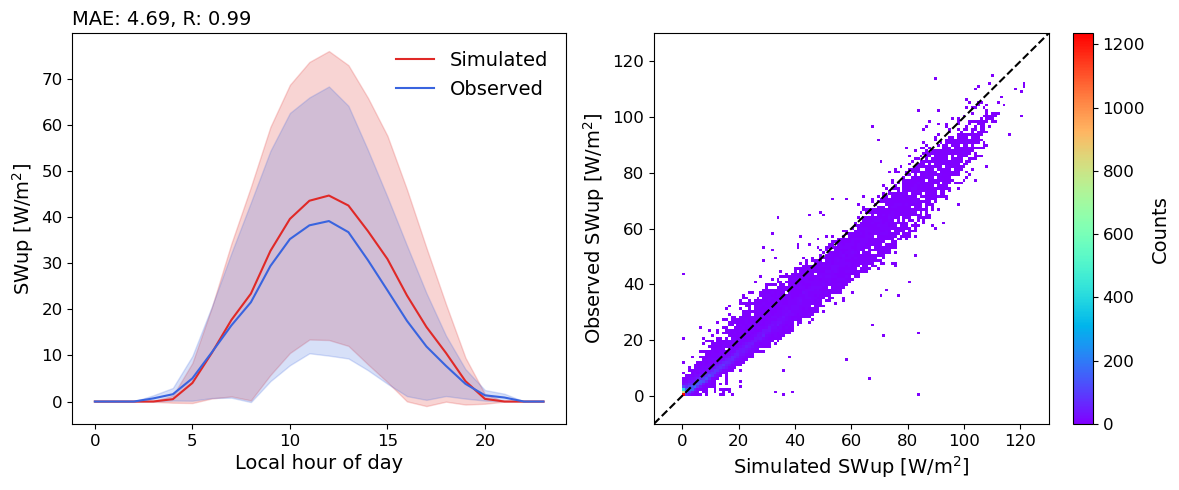

LWup MAE: 5.50


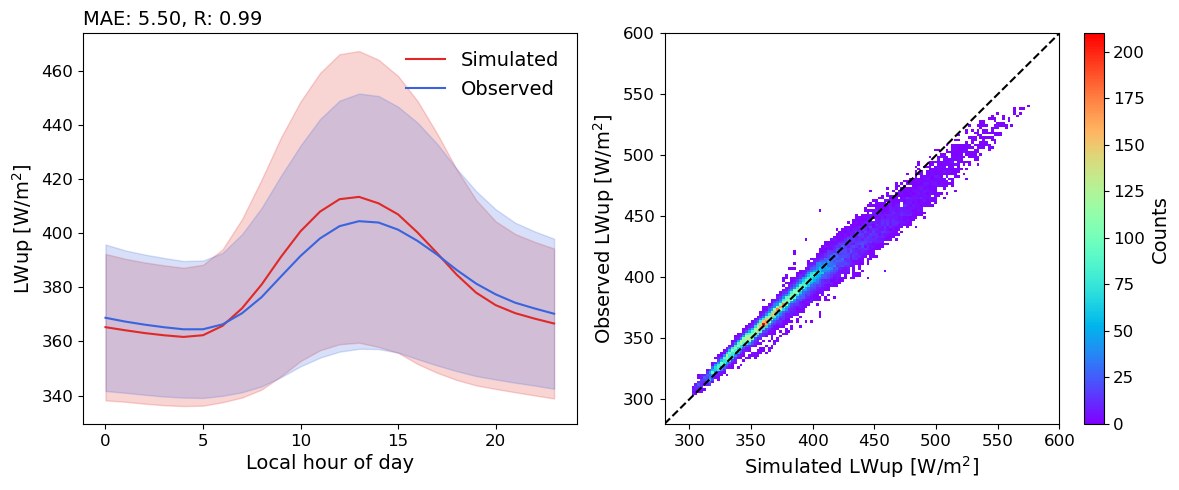

Qle MAE: 23.39


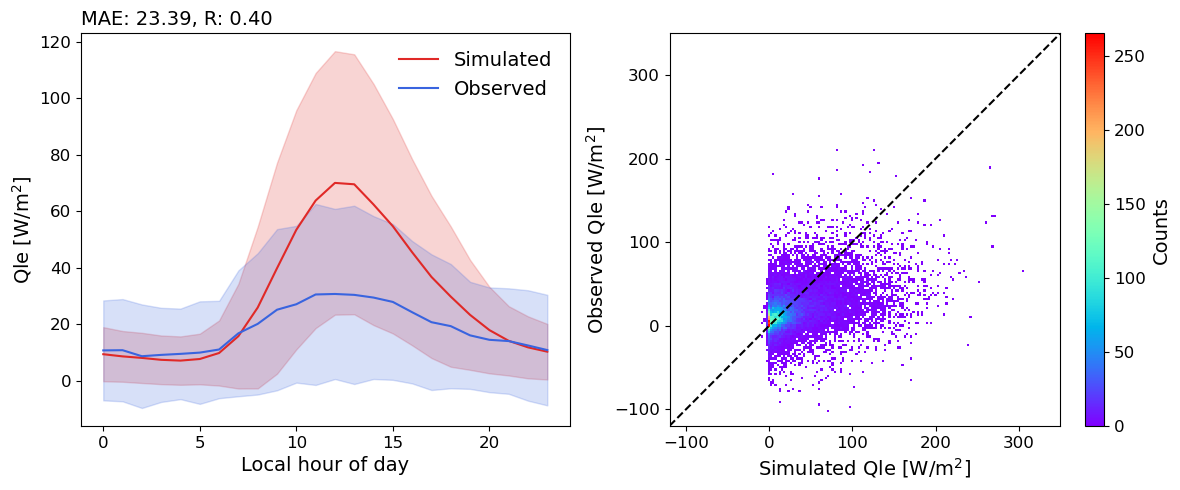

Qh MAE: 52.93


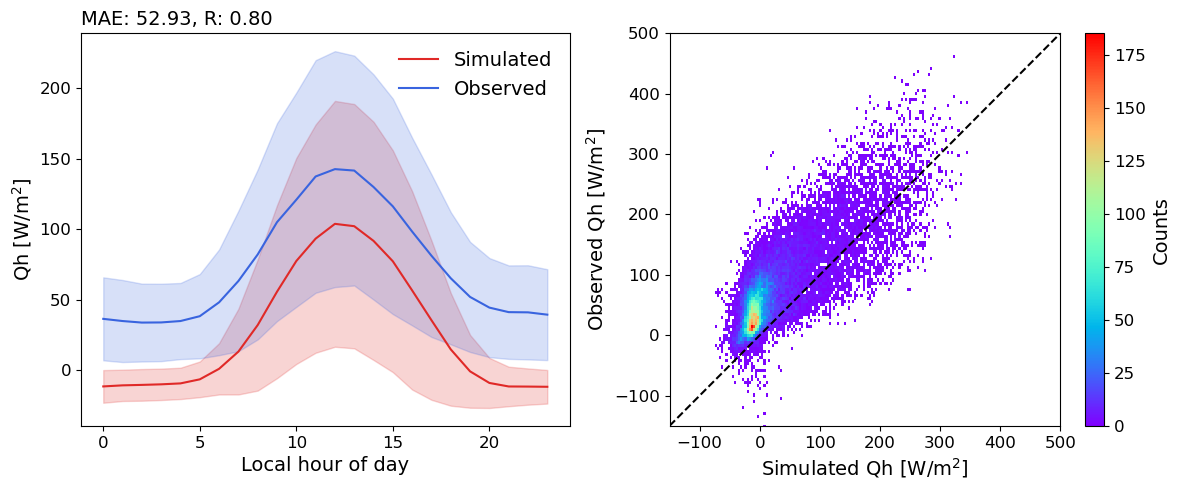

Qtau MAE: 0.16


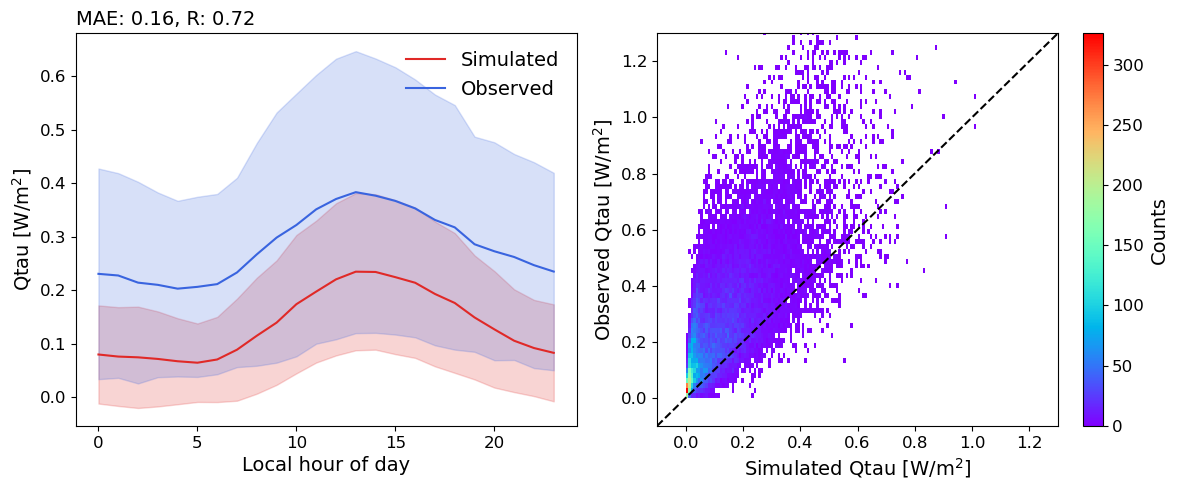

SWup MAE: 7.48


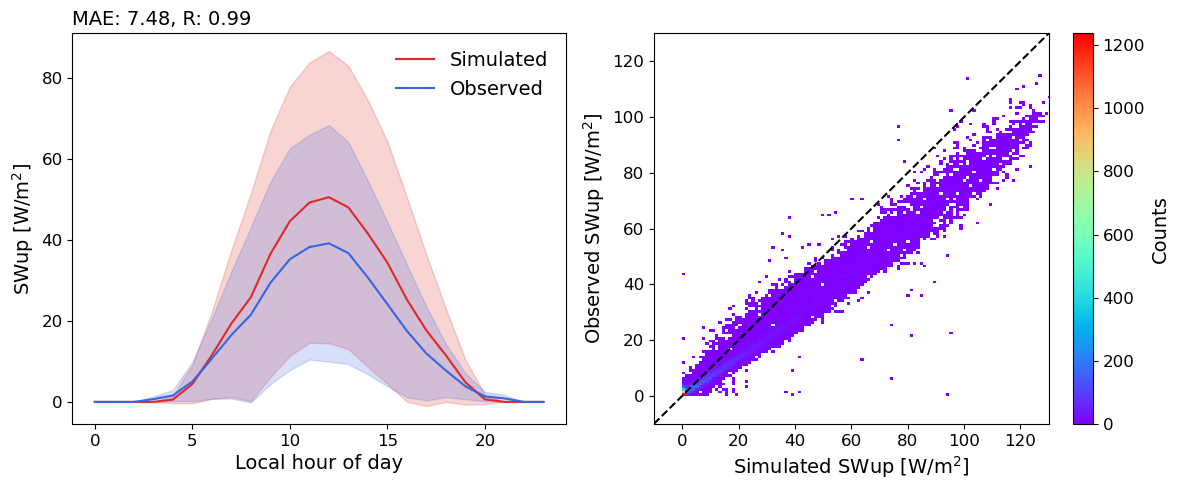

LWup MAE: 7.79


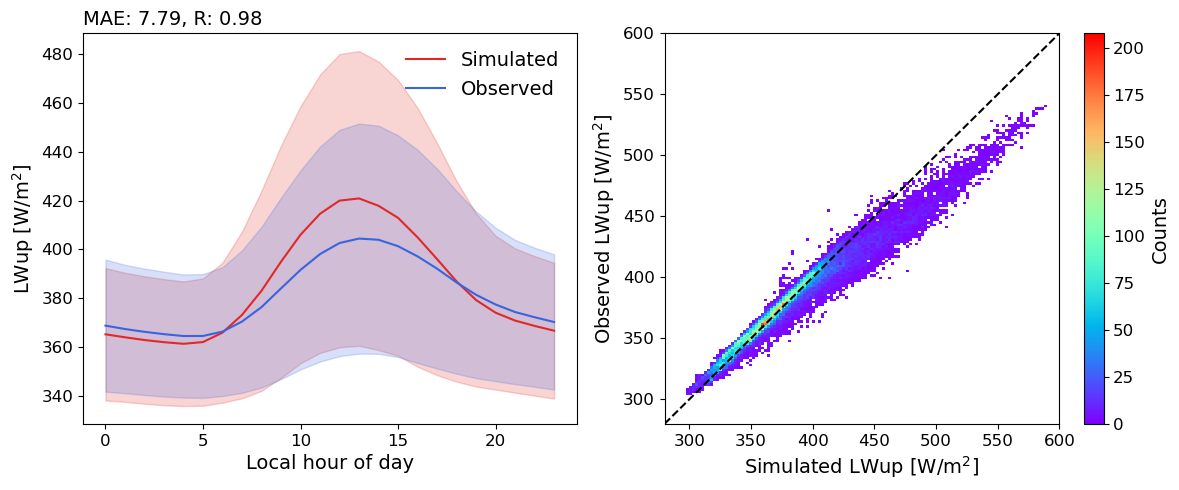

Qle MAE: 18.42


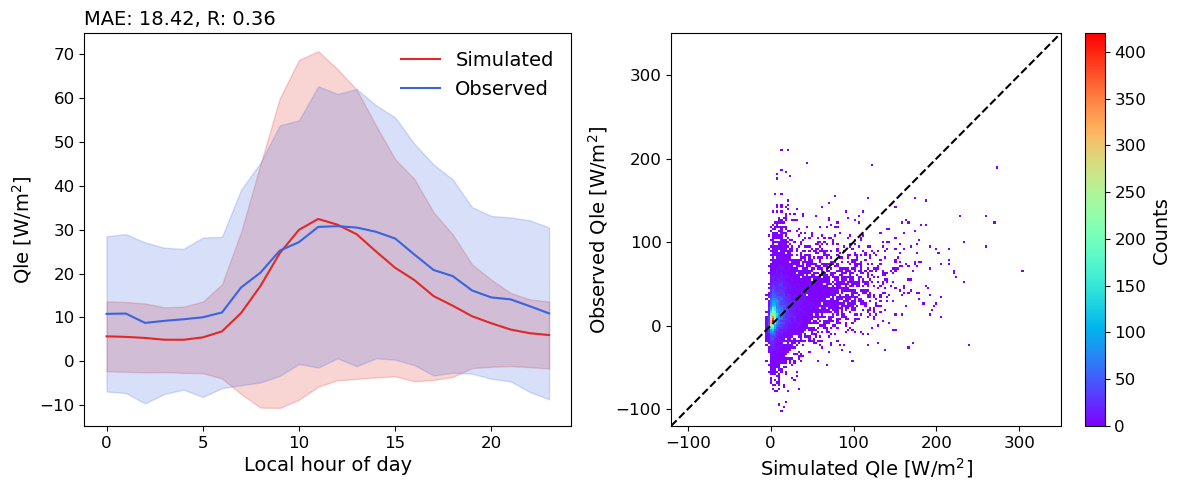

Qh MAE: 50.15


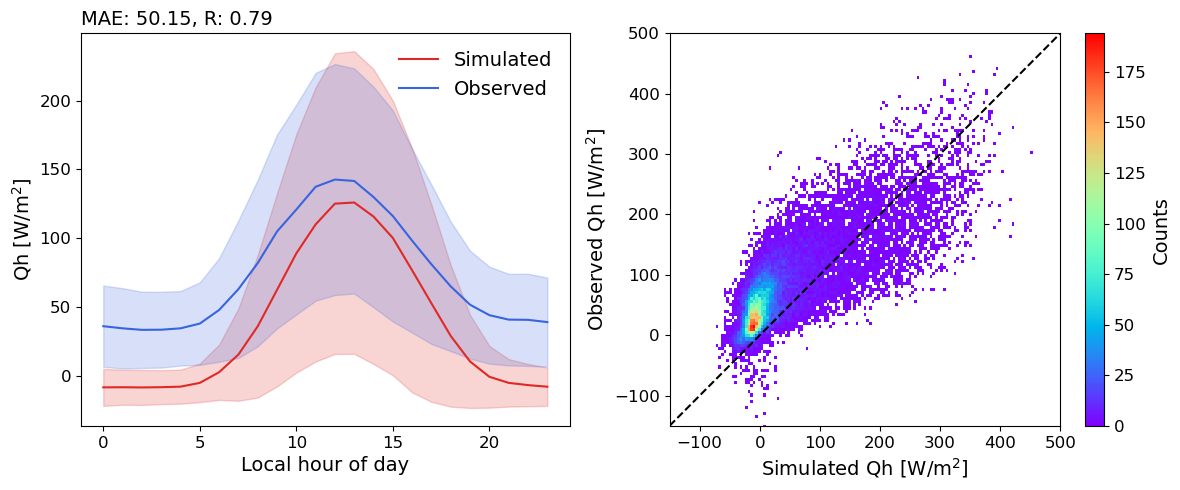

Qtau MAE: 0.15


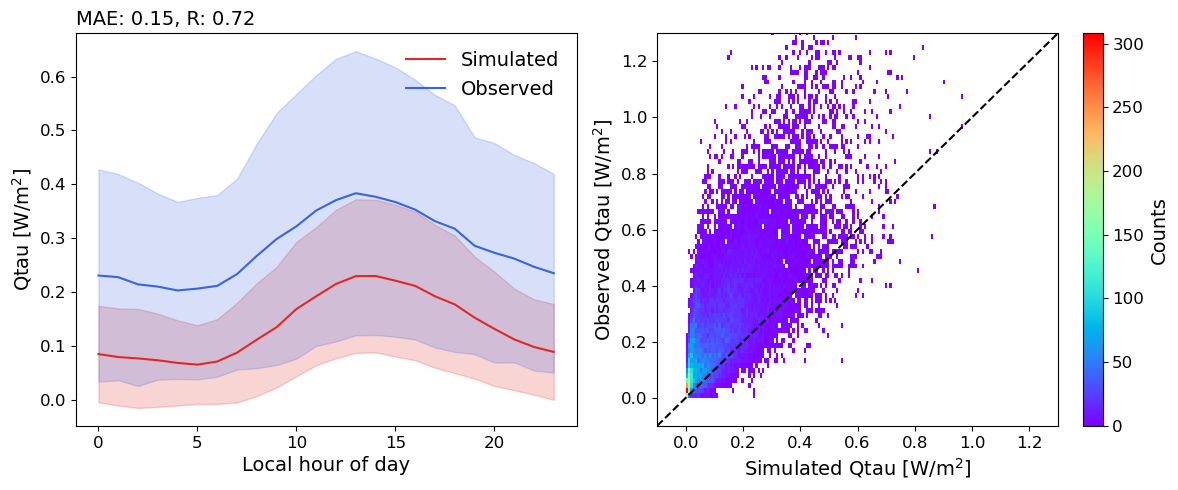

In [10]:
plotting(df, 'figs/CLMU5_UK-Kin_default')
plotting(df_detail, 'figs/CLMU5_UK-Kin_detail')